In [8]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import os

def my_fit(seeds):
    file_name_num = []
    for each in os.listdir('电导数据/')[1:]:
        file_name_num.append("".join(list(filter(str.isdigit, each))))

    def read_G(file_len):
        GD = []
        GP = []

        f_P = open('./电导数据/' + str(file_len) + '权重GP.txt', 'r')
        f_D = open('./电导数据/'+ str(file_len) + '权重GD.txt', 'r')
        for each_P in f_P:
            GP.append(float(each_P.replace('\n', '')))
        for each_D in f_D:
            GD.append(float(each_D.replace('\n', '')))
        
        # return np.array(GP), np.array(GD)
        return abs(np.array(GP)), abs(np.array(GD))

    # while True:
    #     G_num = input('输入电导数据个数(退出输入：quit)：')
    #     if G_num == 'quit':
    #         quit_this = 1
    #         print('程序退出')
    #         break
    #     elif G_num.isdigit() == True:
    #         if G_num in file_name_num:
    #             break
    #         else:
    #             print(f'文件夹内不存在{G_num}个数的电导数据文件！')
    #             print('请重新输入电导数据个数！')
    #             continue
    #     else:
    #         print('请正确输入电导数据个数（数字）!')
    #         continue

    G_num = 50

    GP_tmp, GD_tmp = read_G(int(G_num))

    # GP = (GP_tmp+0.2)/0.3
    # GD = (GD_tmp+0.2)/0.3

    GP = GP_tmp/max(GP_tmp)
    GD = GD_tmp/max(GD_tmp)

    P = np.arange(1, int(G_num), 1)

    GPmax = max(GP)
    GPmin = min(GP)
    GDmax = max(GD)
    GDmin = min(GD)
    xP = GP[:-1]
    yP = GP[1:]
    xD = GD[:-1]
    yD = GD[1:]

    # np.savetxt('GP_ori.txt', GP)
    # np.savetxt('GD_ori.txt', GD)

    # 电导拟合公式 其中aP，aD代表对应部分的步长，bP与bD为非线性度
    # 主要是为了获得非线性度
    def delt_GP(xP, aP, bP):
        yP = xP + aP * np.exp(-bP * ((xP - GPmin) / (GPmax - GPmin)))
        return yP
    def delt_GD(xD, aD, bD):
        yD = xD - aD * np.exp(-bD * ((GDmax - xD) / (GDmax - GDmin)))
        return yD


    np.random.seed(seeds)
    def curve_fit_GP(P, xP, yP, save_path='GP%d.png'):
        # yP 段拟合数据
        while True:
            err_stdev = 0 # 0.2
            yP_noise = err_stdev * np.random.normal(size=yP.size)
            yP_data = yP + yP_noise
            popt, pcov = curve_fit(delt_GP, xP, yP_data)#训练函数
            aP = popt[0]
            bP = popt[1]
            if bP < 0:
                continue
            else:
                break
        yPvals=delt_GP(xP, aP, bP)
        plt.plot(P, yP, '*',label='original values')
        plt.plot(P, yPvals, 'r',label='curve_fit values')
        plt.ylim(0, 1)
        plt.xlabel('P axis')
        plt.ylabel('GP axis')
        plt.legend(loc=4)
        plt.title('curve_fit aP = %0.2f, bP = %0.2f' %(aP, bP))
        # plt.savefig(save_path%int(G_num), dpi=720)
        plt.show()
        return yPvals

    def curve_fit_GD(P, xD, yD, save_path='GD%d.png'):
        # yD 段拟合数据
        while True:
            err_stdev = 0 # 0.2
            yD_noise = err_stdev * np.random.normal(size=xD.size)
            yD_data = yD + yD_noise
            popt, pcov = curve_fit(delt_GD, xD, yD_data)#训练函数
            aD = popt[0]
            bD = popt[1]
            if bD < 0:
                continue
            else:
                break
        yDvals=delt_GD(xD, aD, bD)
        plt.plot(P, yD, '*',label='original values')
        plt.plot(P, yDvals, 'r',label='curve_fit values')
        plt.ylim(0, 1)
        plt.xlabel('P axis')
        plt.ylabel('GD axis')
        plt.legend(loc=3)
        plt.title('curve_fit aD = %0.2f, bD = %0.2f' %(aD, bD))
        # plt.savefig(save_path%int(G_num), dpi=720)
        plt.show()
        return yDvals

    """
    函数说明：将电导数据归一化处理
    Parameters：
        xP, xD - 电导数据
        aP, aD - 步长
        bP. bD - 非线性度
    Result:
        yP, yD - 下一个电导数据
    """
    # def norm_GP(xP, aP, bP, GPmax, GPmin):
    #     yP = ((xP + aP * np.exp(-bP * ((xP - GPmin) / (GPmax - GPmin))) - GPmin) / (GPmax - GPmin) - 0.5) / 0.5
    #     return yP
    # def norm_GD(xD, aD, bD, GDmax, GDmin):
    #     yD = ((xD - aD * np.exp(-bD * ((GDmax - xD) / (GDmax - GDmin))) - GDmin) / (GDmax - GDmin) - 0.5) / 0.5
    #     return yD
    # 生成归一化后的电导数据图像
    # normGP = norm_GP(xP, 2.61, 0.08)
    # plt.plot(P, normGP)
    # plt.show()
    # normGD = norm_GD(xD, -7.09, 1.86)
    # plt.plot(P, normGD)
    # plt.show()

    yDvals = curve_fit_GD(P, xD, yD)
    yPvals = curve_fit_GP(P, xP, yP)

    plt.plot(GP, label='GP')
    plt.plot(GD, label='GD')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.show()
    return yPvals, yDvals

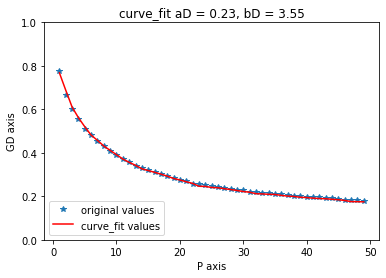

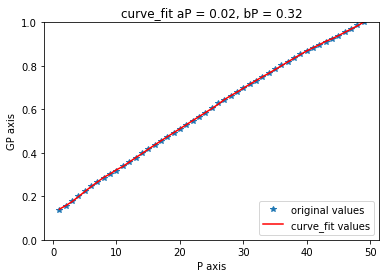

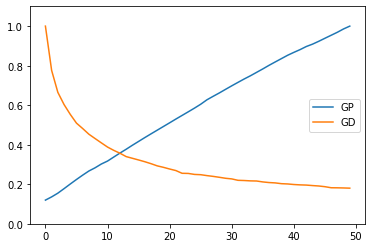

In [9]:
yPvals, yDvals = my_fit(0)

In [17]:
np.savetxt('GP curve_fit values.txt', yPvals)
np.savetxt('GD curve_fit values.txt', yDvals)